In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import numpy as np
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.2.0


In [2]:
len(os.listdir("./new_data/neg/")), len(os.listdir("./new_data/pos/"))      # 边缘检测 + 形态学操作

(479, 225)

In [3]:
folder = ["./new_data/pos/",  "./new_data/neg/"]

filenames = []
labels = []
for category in [0,1]:
# 每个循环代表一个类别的所有图片
    now_folder = folder[category]
    for file in os.listdir(now_folder):
        filename = os.path.abspath(now_folder+file)
        filenames.append(filename)        
        labels.append(category)
    print(filename, category, len(filenames))
        
neg_num = sum(labels)
pos_num = len(filenames) - neg_num
print('pos_num=',pos_num, 'neg_num=',neg_num )
if neg_num > pos_num:
    filenames = filenames[:2*pos_num]
    labels = labels[:2*pos_num]
neg_num = sum(labels)
pos_num = len(filenames) - neg_num
print('pos_num=',pos_num, 'neg_num=',neg_num )

D:\ML\data_C\new_data\pos\97.png 0 225
D:\ML\data_C\new_data\neg\99.png 1 704
pos_num= 225 neg_num= 479
pos_num= 225 neg_num= 225


(1200, 1400) 1.0 0.0 [0. 0. 0. 0. 0.]


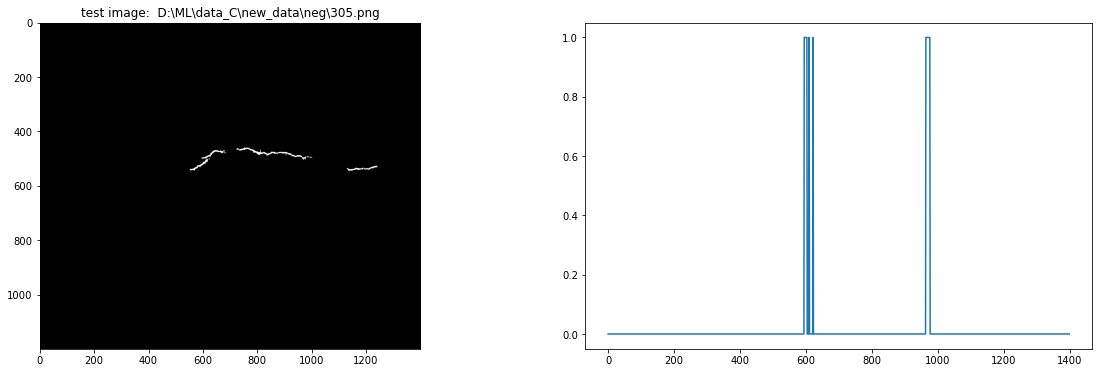

In [4]:
image = plt.imread(filenames[-1]) 
print(image.shape, np.max(image), np.min(image),np.array(image)[0,:5])
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(image,cmap='gray')
plt.title('test image:  '+filenames[-1])

plt.subplot(122)
plt.plot(image[500])
plt.show()

In [5]:
tra_filenames = []
tra_labels = []

tes_filenames = []
tes_labels = []

for i in range(len(filenames)):
    if i % 5 != 0:
        tra_filenames.append(filenames[i])
        tra_labels.append(labels[i])
    else:
        tes_filenames.append(filenames[i])  
        tes_labels.append(labels[i])
print(len(tra_filenames),  len(tes_filenames))
tra_filenames[:5], tra_labels[:5] ,tes_filenames[:5], tes_labels[:5]

360 90


(['D:\\ML\\data_C\\new_data\\pos\\100.png',
  'D:\\ML\\data_C\\new_data\\pos\\103.png',
  'D:\\ML\\data_C\\new_data\\pos\\104.png',
  'D:\\ML\\data_C\\new_data\\pos\\106.png',
  'D:\\ML\\data_C\\new_data\\pos\\109.png'],
 [0, 0, 0, 0, 0],
 ['D:\\ML\\data_C\\new_data\\pos\\10.png',
  'D:\\ML\\data_C\\new_data\\pos\\107.png',
  'D:\\ML\\data_C\\new_data\\pos\\122.png',
  'D:\\ML\\data_C\\new_data\\pos\\129.png',
  'D:\\ML\\data_C\\new_data\\pos\\137.png'],
 [0, 0, 0, 0, 0])

In [6]:
def parse_function(pic_path, label, is_train):
# 图像读取和调整以使其成为方便训练的数据集
# 注意这里传进来的是单个图片的存储路径和类别
    img_string = tf.io.read_file(pic_path)
    img_decoded = tf.io.decode_jpeg(img_string, channels=1)                                    # [   1200  1400  1]  解码图像   

    if is_train:
        img = tf.image.random_crop(img_decoded, [1024,1280,1])                             #  随机裁剪
        img = tf.image.resize(img,[512, 640])
        img = tf.image.random_flip_left_right(img)                                         #  随机左右翻转
        img = tf.image.random_flip_up_down(img)                                            #  随机上下翻转
    else:
        img = tf.image.crop_to_bounding_box(img_decoded, 88, 60, 1024, 1280)               #  固定裁剪
        img = tf.image.resize(img,[512, 640])

        
    img = tf.cast(img, dtype = tf.float32)
    img = img > 0
    return img, label

batch_size = 40

traset = tf.data.Dataset.from_tensor_slices((tra_filenames, tra_labels)).repeat().shuffle(10000)
traset = traset.map(lambda d,l:parse_function(d,l,True)).batch( batch_size)

tesset = tf.data.Dataset.from_tensor_slices((tes_filenames, tes_labels)).repeat().shuffle(10000)
tesset = tesset.map(lambda d,l:parse_function(d,l,False)).batch( batch_size)

next(traset.__iter__())[0].numpy().shape, next(tesset.__iter__())[0].numpy().shape

((40, 512, 640, 1), (40, 512, 640, 1))

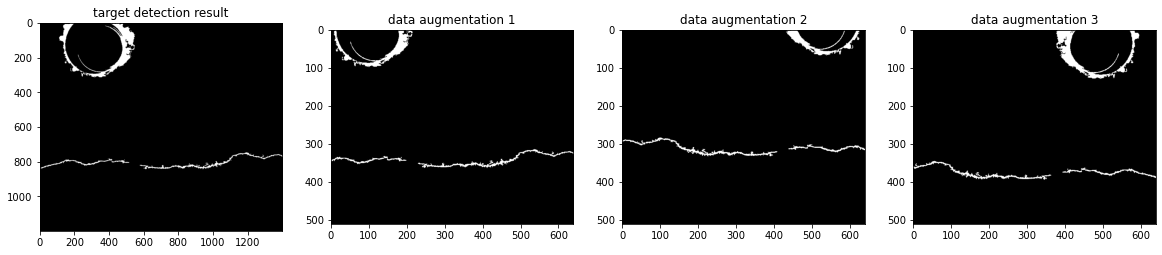

In [7]:
sn=4
fn = ['.\\new_data\\neg\\478.png']*100
fl = [0 for i in range(len(fn))]

plt.figure(figsize=[20,5])
plt.subplot(1,sn,1)
image = plt.imread(fn[0]) 
plt.imshow(image,cmap='gray')
plt.title('target detection result')

one_batch_data,  one_batch_label = next(tf.data.Dataset.from_tensor_slices((fn, fl)).map(lambda d,l:parse_function(d,l,True)).batch(20).__iter__())
for i in range( 2,sn+1 ):
    img_val = one_batch_data[i].numpy()
    plt.subplot(1,sn,i)
    img_val = img_val[:,:,0]    #灰色图
    plt.imshow(img_val,cmap='gray')
    plt.title('data augmentation ' + str(i-1))
plt.show()

# 构建模型

In [8]:
# model.evaluate(val_dataset  , steps = 10)  # 使用测试数据集进行评估模型准确度

# model.load_weights('./save/my_model_weights')

# model.evaluate(val_dataset  , steps = 10)  # 使用测试数据集进行评估模型准确度

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

L2 = tf.keras.regularizers.l2()
af = 'relu'

inputs_ = tf.keras.Input(shape=[512,640,1],name='inputs_')

##############################################################################################################
start_conv1 = layers.Conv2D(16,  5, strides=2,activation=af,padding='same',name='start_conv1')(inputs_)
start_mp1 = layers.MaxPool2D(name = 'start_mp1')(start_conv1)
start_conv2 = layers.Conv2D(32,  5, strides=2,activation=af,padding='same',name='start_conv2')(start_mp1)
start_mp2 = layers.MaxPool2D(name = 'start_mp2')(start_conv2)

stage1 = layers.Conv2D(64,  3, strides=1,activation=af,padding='same',name='conv1')(start_mp2)
stage1 = layers.MaxPool2D(name = 'conv1_mp')(stage1)
stage2 = layers.Conv2D(128,  3, strides=1,activation=af,padding='same',name='conv2')(stage1)
stage2 = layers.MaxPool2D(name = 'conv2_mp')(stage2)
stage3 = layers.Conv2D(256,  3, strides=1,activation=af,padding='same',name='conv3')(stage2)
stage3 = layers.MaxPool2D(name = 'conv3_mp')(stage3)

g4 = layers.Flatten(name='flatten')(stage3)
# ##############################################################################################################
Drop = layers.Dropout(0.5,  name='Drop')(g4)
output_ = layers.Dense( units = 2,activation = 'softmax',name='output_')(Drop)

model = tf.keras.Model(inputs=inputs_, outputs=output_, name='model')
model.summary()

model.compile(optimizer = tf.keras.optimizers.Adam(1e-4),   
              loss      = 'sparse_categorical_crossentropy',  # 交叉熵   tf.losses.softmax_cross_entropy  'sparse_categorical_crossentropy'
              metrics   = ['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_ (InputLayer)         [(None, 512, 640, 1)]     0         
_________________________________________________________________
start_conv1 (Conv2D)         (None, 256, 320, 16)      416       
_________________________________________________________________
start_mp1 (MaxPooling2D)     (None, 128, 160, 16)      0         
_________________________________________________________________
start_conv2 (Conv2D)         (None, 64, 80, 32)        12832     
_________________________________________________________________
start_mp2 (MaxPooling2D)     (None, 32, 40, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 40, 64)        18496     
_________________________________________________________________
conv1_mp (MaxPooling2D)      (None, 16, 20, 64)        0     

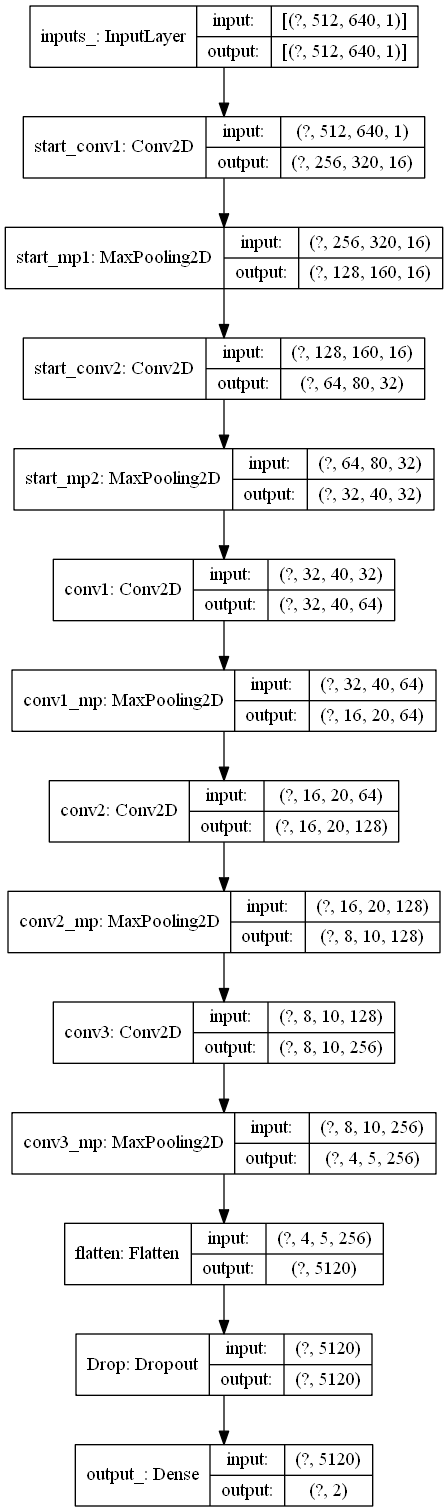

In [10]:
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_model(model,show_shapes=True,show_layer_names=1,)

In [11]:
t_start = time.clock()
h = model.fit(  traset,      epochs=5,        steps_per_epoch = 1 ,)
t_end   = time.clock()
train_time = t_end - t_start
print('train_time:\t',train_time)

# model.save_weights('./save/my_model_weights')

Epoch 1/5
1/1 [==============================] - 0s 997us/step - loss: 0.6980 - accuracy: 0.5500
Epoch 2/5
1/1 [==============================] - 0s 997us/step - loss: 0.6891 - accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 0s/step - loss: 0.6868 - accuracy: 0.5500
Epoch 4/5
1/1 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 998us/step - loss: 0.6806 - accuracy: 0.5000
train_time:	 3.158265


In [12]:
# model.load_weights('./save/model.h5')
model.evaluate(traset  , steps = 10)  # 使用测试数据集进行评估模型准确度
model.evaluate(tesset  , steps = 10)  # 使用测试数据集进行评估模型准确度

10/10 [==============================] - 2s 194ms/step - loss: 0.6725 - accuracy: 0.5250


[0.6724612712860107, 0.5249999761581421]

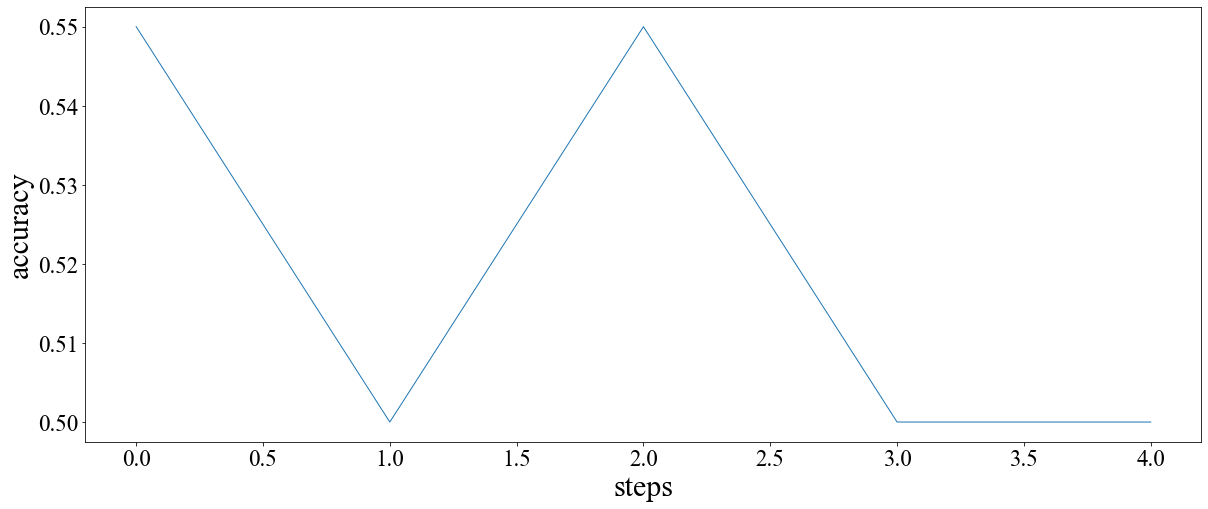

In [13]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30,
}

figure, ax = plt.subplots(figsize=[20,8])
plt.plot(h.history['accuracy'], linewidth=1)

plt.tick_params(labelsize=23)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.xlabel(xlabel='steps',     fontdict=font)
plt.ylabel(ylabel='accuracy',  fontdict=font)
plt.savefig('acc_steps_527.png')

# 训练后不轻易加载和保存

In [14]:
# model.save('./save/model.h5')